In [1]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

RANDOM_SEED = 42

In [2]:
dataset = 'model/keypoint_classifier/keypoint_original_data_v2.csv'
model_save_path = 'model/keypoint_classifier/fnn_mediapipe_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/fnn_mediapipe_classifier.tflite'

In [3]:
NUM_CLASSES = 26

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
# Normalize the dataset
X_dataset = X_dataset / np.max(X_dataset)

In [5]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_dataset), y=y_dataset)
class_weights = dict(enumerate(class_weights))

In [6]:
# Split the data into 60% train, 20% validation, and 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X_dataset, y_dataset, test_size=0.4, random_state=RANDOM_SEED, stratify=y_dataset)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=y_temp)

In [7]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(((21 * 2),)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
# Early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True, verbose=1)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

In [9]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

In [10]:
# Build and train the model on the training set
model = build_model()

In [11]:
# Train the model
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_val, y_val), callbacks=[es_callback, lr_callback], class_weight=class_weights, verbose=1)

Epoch 1/1000
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5629 - loss: 1.5036 - val_accuracy: 0.9569 - val_loss: 0.1729 - learning_rate: 0.0010
Epoch 2/1000
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9037 - loss: 0.3138 - val_accuracy: 0.9744 - val_loss: 0.0986 - learning_rate: 0.0010
Epoch 3/1000
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9331 - loss: 0.2194 - val_accuracy: 0.9797 - val_loss: 0.0792 - learning_rate: 0.0010
Epoch 4/1000
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9445 - loss: 0.1839 - val_accuracy: 0.9805 - val_loss: 0.0742 - learning_rate: 0.0010
Epoch 5/1000
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9508 - loss: 0.1690 - val_accuracy: 0.9811 - val_loss: 0.0668 - learning_rate: 0.0010
Epoch 6/1000
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9539 - loss: 0.1548 - val_accuracy: 0.9838 - val_loss: 0.0599 - learning_rate: 0.0010
Epoch 7/1000
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accura

In [12]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

Validation Loss: 0.022613124921917915, Validation Accuracy: 0.9945330619812012


1464/1464 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step


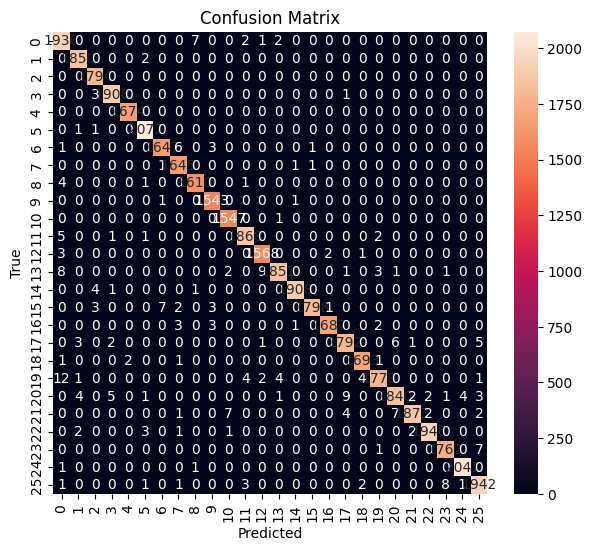

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1948
           1       0.99      1.00      1.00      1852
           2       0.99      1.00      1.00      1794
           3       1.00      1.00      1.00      1910
           4       1.00      1.00      1.00      1674
           5       1.00      1.00      1.00      2074
           6       0.99      0.99      0.99      1658
           7       0.99      1.00      0.99      1648
           8       0.99      1.00      1.00      1616
           9       0.99      1.00      1.00      1545
          10       0.99      1.00      1.00      1548
          11       0.99      1.00      0.99      1877
          12       0.99      1.00      0.99      1574
          13       1.00      0.99      0.99      1876
          14       1.00      1.00      1.00      1914
          15       1.00      0.99      1.00      1814
          16       1.00      0.99      1.00      1696
     

In [13]:
# Predict and print confusion matrix and classification report for the validation set
y_pred = np.argmax(model.predict(X_val), axis=1)
print_confusion_matrix(y_val, y_pred, report=True)

In [14]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

Test Loss: 0.018055032938718796, Test Accuracy: 0.9950028657913208


1464/1464 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step


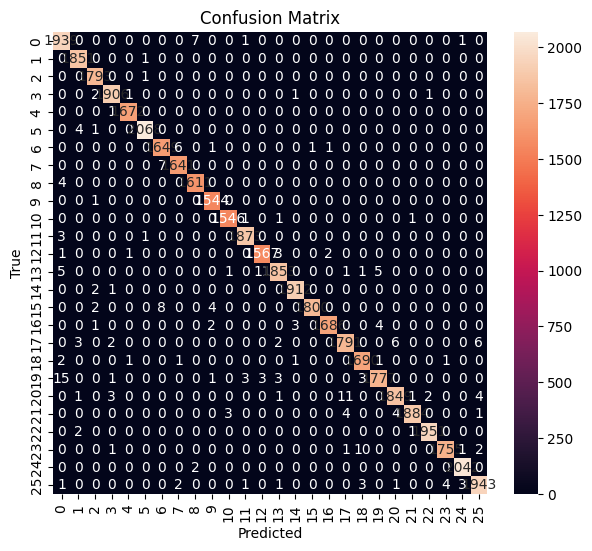

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1948
           1       0.99      1.00      1.00      1852
           2       1.00      1.00      1.00      1794
           3       1.00      1.00      1.00      1911
           4       1.00      1.00      1.00      1673
           5       1.00      1.00      1.00      2073
           6       0.99      0.99      0.99      1658
           7       0.99      1.00      1.00      1648
           8       0.99      1.00      1.00      1615
           9       0.99      1.00      1.00      1545
          10       1.00      1.00      1.00      1549
          11       1.00      1.00      1.00      1877
          12       0.99      1.00      0.99      1574
          13       0.99      0.99      0.99      1877
          14       1.00      1.00      1.00      1915
          15       1.00      0.99      1.00      1814
          16       1.00      0.99      1.00      1696
     

In [15]:
# Predict and print confusion matrix and classification report for the test set
y_pred_test = np.argmax(model.predict(X_test), axis=1)
print_confusion_matrix(y_test, y_pred_test, report=True)

In [16]:
# Save the model after training
final_model = build_model()

In [17]:
# Train the final model on the entire dataset
final_model.fit(
    X_dataset,
    y_dataset,
    epochs=1000,
    batch_size=128,
    callbacks=[es_callback, lr_callback],
    class_weight=class_weights,
    verbose=1
)

Epoch 1/1000
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6585 - loss: 1.1647 - learning_rate: 0.0010
Epoch 2/1000
 116/1830 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9257 - loss: 0.2400

c:\Users\newyo\Desktop\Senior-Project\venv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\newyo\Desktop\Senior-Project\venv\lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


1830/1830 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9318 - loss: 0.2279 - learning_rate: 0.0010
Epoch 3/1000
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9460 - loss: 0.1807 - learning_rate: 0.0010
Epoch 4/1000
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9546 - loss: 0.1559 - learning_rate: 0.0010
Epoch 5/1000
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9577 - loss: 0.1441 - learning_rate: 0.0010
Epoch 6/1000
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9625 - loss: 0.1277 - learning_rate: 0.0010
Epoch 7/1000
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9633 - loss: 0.1257 - learning_rate: 0.0010
Epoch 8/1000
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9640 - loss: 0.1214 - learning_rate: 0.0010
Epoch 9/1000
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9659 - loss: 0.1150 - learning_rate: 0.0010
Epoch 10/1000
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9664 - loss: 0.1136 - learning

In [18]:
# Save the final model as a model dedicated to inference
final_model.save(model_save_path, include_optimizer=False)

In [19]:
# Convert the model to TFLite (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the TFLite model
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\newyo\AppData\Local\Temp\tmp5ct3fz6l\assets


INFO:tensorflow:Assets written to: C:\Users\newyo\AppData\Local\Temp\tmp5ct3fz6l\assets


Saved artifact at 'C:\Users\newyo\AppData\Local\Temp\tmp5ct3fz6l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  2479356147520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2479356148400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2479356142944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2479356145232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2479356144000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2479356382720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2479356381664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2479356381840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2479356382544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2479356381312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2479356380

In [20]:
# TFLite inference test
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [21]:
# Get I/O tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
# Set input tensor
interpreter.set_tensor(input_details[0]['index'], np.array([X_dataset[0]]))

In [23]:
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [24]:
print("TFLite Prediction Result:", np.squeeze(tflite_results))
print("TFLite Predicted Class:", np.argmax(np.squeeze(tflite_results)))

TFLite Prediction Result: [9.9997818e-01 2.5038559e-16 1.1068435e-11 2.1967770e-13 9.2792978e-12
 1.3439660e-11 9.3059329e-09 1.4150507e-11 1.1594016e-05 1.0524714e-07
 3.3257196e-11 1.0190207e-07 4.2317527e-08 1.1154417e-07 1.2847241e-09
 1.7541884e-09 3.1757097e-09 7.5509293e-11 1.0955140e-08 9.8148403e-06
 2.7527572e-11 5.7533336e-12 4.0315555e-12 5.7108429e-10 7.8678369e-08
 2.1251119e-09]
TFLite Predicted Class: 0
